# LoadDataset

在使用Pytorch搭建AlexNet之前,我们需要知道如何使用Pytorch高效的加载数据.

你可能需要先详读[data-loading-and-processing-tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#data-loading-and-processing-tutorial),该内容包含了Pytorch官方建议加载数据集的方式.

In [1]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader

### 1. LoadCatsVsDogs

我们这里依然使用的是CatsVsDogs 数据集,我们加载数据的最终目标是能够给模型提供ndarray形式的batch sample以及0,1的label.所以:

[1] 我们需要先将图片使用PIL读取出来,当然你也可以使用Matplotlib或者skimage或者io.其中官方案例中使用的是```io.imread```.需要注意的是如果使用的是PIL读取图片它的shape是$(W \times H)$.

[2] 读取了之后我们需要将其resize到指定的$(W \times H)$,和Tensorflow中一样,对于AlexNet模型加载数据集步骤,我们不做随机裁剪,水平翻转以及PCA操作.

[3] 将标签进行划分,在这里我们指定cat:0,dog:1.

[4] 对于该类中的```transform=None```参数是选择一个transform 来应用一个样本.在后面会使用.

[5] 类中函数```__getitem__```是继承于```Dataset```的一个迭代器,支持索引操作,好处是内存效率高,因为所有图像不会立即存储在内存中,而是根据需要读取.

In [2]:
class LoadCatsVsDogs(Dataset):
    """
    加载数据集并继承Dataset类
    """
    def __init__(self, file_dir, n_h, n_w, transform=None):
        """
        初始化类
        Args:
        ----
            file_dir (string): 数据集图片的目录.
            n_h (int): resize 指定的图片高
            n_w (int): resize 指定的
            transform (callable, optional): 选择一个transform 来应用一个样本.
        """
        self.file_dir = file_dir
        self.list_dirs = os.listdir(self.file_dir)
        self.n_h = n_h
        self.n_w = n_w
        self.transform = transform

    def __len__(self):
        """
        返回样本总数
        """
        return len(self.list_dirs)
    
    def __getitem__(self,idx):
        """
        getitem是类Dataset中的一个迭代器.
        """
        image_name = self.list_dirs[idx]
        image_path = os.path.join(self.file_dir,image_name)
        # 图片名形式:{classes}.N.jpg,所以使用split拆分.
        classes = image_name.split('.',1)[0]
       
        if classes == 'cat':
            label = 0
        else:
            label = 1

        # resize
        image = Image.open(image_path)
        image = image.resize((self.n_w,self.n_h))
        image = np.array(image)

        sample = {'image':image,'label':label}
        
        if self.transform:
            sample = self.transform(sample)
       
        return sample

下面我们来尝试一下迭代出三张图片并且显示.

The Total Sample:25000


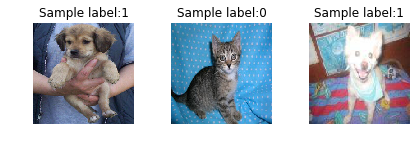

In [3]:
n_h,n_w = 224,224
file_dir='/Users/huwang/Joker/Data_Set/catVSdot/train'

CatsDogs_dataset = LoadCatsVsDogs(file_dir=file_dir,n_h=n_h,n_w=n_w)
print('The Total Sample:{}'.format(len(CatsDogs_dataset)))

fig = plt.figure()
for i in range(3):
    sample = CatsDogs_dataset[i]
    ax = plt.subplot(1,3,i+1)
    # Automatically adjust subplot parameters to give specified padding.
    plt.tight_layout()
    ax.set_title('Sample label:{}'.format(sample['label']))
    ax.axis('off') # trun of axis
    plt.imshow(sample['image'])
plt.show()

### 2. ToTensor

现在我们已经能够拿出图片并且resize到我们指定的$(W\times H)$了,我们需要将其转换为Tensor以便于Pytorch进行运算和梯度渐变.

[1] 我们在```LoadCatsVsDogs(Dataset)```类中返回出来的是一个字典,其中包括```{'image':image,'label':label}```.

[2] 因为我们使用的是PIL,所以对应的ndarray shape 是$(W\times H\times C)$.

[3] 由于Pytorch的CONV2默认支持的tensor形状是$(C\times H\times C)$,所以我们需要将其reshape为该形状.

[4] 最后我们将其转换为Torch.

In [4]:
class ToTensor:
    """
    Change to Tensor
    """
    def __call__(self,sample):
        image,label = sample['image'],sample['label']
        
        n_w,n_h,n_c = image.shape
        # numpy image: W x H x C
        # torch image: C X H X W
        image = image.reshape((n_c,n_h,n_w))
        image = torch.from_numpy(image)
        label = torch.FloatTensor([label])
      
        return {'image':image,'label':label}

由于我们这里定义的是```__call__```方法,所以我们可以直接调用实例即可.还记得我们```LoadCatsVsDogs(Dataset)```类中的```transform```参数吗?现在我们将```ToTensor```传入使得将字典中的```image,label```转换为Tensor.

下面我们就来看看前三个sample是否成功转换为Tensor.

In [5]:
n_h,n_w = 224,224
file_dir='/Users/huwang/Joker/Data_Set/catVSdot/train'

CatsDogs_dataset = LoadCatsVsDogs(file_dir=file_dir,n_h=n_h,n_w=n_w,transform=ToTensor())

for i in range(3):
    sample = CatsDogs_dataset[i]

    print(i,sample['image'].size(),sample['label'])

0 torch.Size([3, 224, 224]) tensor([1.])
1 torch.Size([3, 224, 224]) tensor([0.])
2 torch.Size([3, 224, 224]) tensor([1.])


可以看到能够成功转换,如果你有多个transform需要同时应用于sample,那么你可以使用Pytorch中的```torchvision.transforms.Compose```.比如案例中的:

<img src="../../../../../picture/208.png" heigt=500 width=500>

其中Rescale是官方案例中定义用于缩放图像的类,crop为随机裁剪目标大小图片.如果想同时将这两个transform应用于一个sample,即可以使用[transforms.Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose)接受的是一个列表的形式.

比如下面我们要将图片做特征工程--标准化.

### 2.1 Normal

Pytorch提供[transforms.Normalize](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize)来标准化图片,但是需要输入各个通道下```mean```与```std```参数,我们需要手动计算:

```python
mean = torch.mean(image_resize, dim=-1).numpy()
std = torch.std(image_resize, dim=-1).numpy()```

这里转换为numpy的原因是:这两个只是一个参数,没有必要使用tensor类型,如果你传递的是tensor类型,那么Pytorch将会报出警告.

![](../../../../../picture/210.png)

In [6]:
class Normal_:
    """
    Normal Image
    """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.float()
        n_c, n_h, n_w = image.size()
        image_resize = torch.reshape(image, shape=(n_c, -1))
        mean = torch.mean(image_resize, dim=-1).numpy()
        std = torch.std(image_resize, dim=-1).numpy()
        normal = transforms.Normalize(mean=mean, std=std)
        image = normal(image)

        return {'image': image, 'label': label}

In [7]:
n_h,n_w = 224,224
file_dir='/Users/huwang/Joker/Data_Set/catVSdot/train'
composed = transforms.Compose([ToTensor(),Normal_()])
CatsDogs_dataset = LoadCatsVsDogs(file_dir=file_dir,n_h=n_h,n_w=n_w,transform=composed)

for i in range(1):
    sample = CatsDogs_dataset[i]
    print('Current image:')
    print(sample['image'])
    print('Currect Label:')
    print(sample['label'])

Current image:
tensor([[[-1.6151, -1.4528, -1.1892,  ...,  2.8054,  1.3049,  1.7713],
         [ 2.7852,  1.1427,  1.7105,  ..., -0.7228,  0.3721, -0.9865],
         [-0.6417,  0.2505, -1.0878,  ...,  1.2846,  1.8321,  2.7040],
         ...,
         [ 1.4063,  1.1832,  1.6496,  ...,  0.4127,  0.9805,  1.9538],
         [-1.7773, -1.6962, -1.6759,  ...,  0.7777,  0.2505,  0.2910],
         [ 0.0071,  0.8182,  0.5546,  ...,  1.3657,  1.2441,  1.6699]],

        [[ 1.0606,  0.8645,  1.1477,  ...,  0.1457,  0.8427,  1.9101],
         [-2.5554, -2.5554, -2.5554,  ..., -0.1810, -0.0504, -0.0286],
         [-0.4207,  0.3200,  0.0586,  ...,  0.9081,  0.7774,  1.2348],
         ...,
         [-1.6187, -0.7474, -1.2484,  ..., -1.2484, -1.3137, -0.5296],
         [-1.0741, -1.1613, -0.4207,  ..., -1.7712, -1.5969, -1.1395],
         [-0.6385, -1.0741, -1.2266,  ..., -1.6187, -0.8781, -1.4009]],

        [[-0.8976, -0.1843, -0.7073,  ..., -0.3269, -0.3982,  0.3388],
         [-0.2318, -0.3269,  0

### 3. Iterating 

现在我们图片的目标预处理就整理完毕,接下去我们就可以迭代出batch size的sample,但是需要注意的是,我们一定不能使用for loop.应该使用[DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader),这样我们可以使用:

- batch size.

- shuffle.

- multiprocessing workers.

In [8]:
CatsDogs_dataset = LoadCatsVsDogs(file_dir=file_dir,n_h=n_h,n_w=n_w,transform=ToTensor())

dataloader = DataLoader(CatsDogs_dataset, batch_size=4, shuffle = True, num_workers=2)

for index,sample in enumerate(dataloader):
        print(index, sample['image'].size(), sample['label'].size())
        if index == 4:
            break

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 1])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 1])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 1])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 1])
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 1])


### 4. Crop

我们知道AlexNet模型在测试阶段,输入一张$(256\times 256)$的图片,截取四个角以及中心后得到5张图片并将其水平翻转得到10张图片,最后取概率最大类.

在Pytorch中[transforms.FiveCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.FiveCrop)可以直接获取四个角以及中心5张图片,其返回一个tuple,并且tuple中是PIL对象,这意味着我们可以使用PIL中的方法.

#### 4.1 FiveCrop

In [9]:
file_path = 'cat.jpg'
five_crop = transforms.FiveCrop((224,224))

image = Image.open(file_path)
image = image.resize((256,256))

Five_image = five_crop(image) # return PIL type

print('The FiveCrop Result:\n',Five_image)

The FiveCrop Result:
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x11CD80B70>, <PIL.Image.Image image mode=RGB size=224x224 at 0x11CDB2470>, <PIL.Image.Image image mode=RGB size=224x224 at 0x11CDB2FD0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x11CD928D0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x11CD92E48>)


我们可以随意查看其中一张,比如左上角.

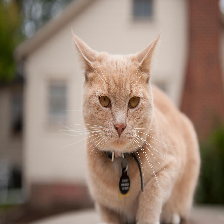

In [10]:
Five_image[0]

由于tuple中的对象是PIL,那么我们就可以使用```img.transpose(Image.FLIP_LEFT_RIGHT)```来将其水平翻转,最后统一转换成ndarray拼接到一个$(10\times 224\times 224\times 3)$的ndarray.

In [11]:
class Crop:
    """
    Crop Picture.
    """
    def __init__(self, file_path, size):
        """
        file_path (string): 测试样本的路径
        size (tuple): 裁剪的大小,是一个tuple,其中包含(H,W)
        """
        self.file_path = file_path
        # H x W
        self.five_crop = transforms.FiveCrop(size)

    def __call__(self):
        
        image = Image.open(self.file_path)
        image = image.resize((256,256))
        Five_image = self.five_crop(image) # return PIL type
        transpose_ = [img.transpose(Image.FLIP_LEFT_RIGHT) for img in Five_image]
        transpose_array = [np.array(img) for img in transpose_]
        img_array = [np.array(img) for img in Five_image]

        image_array = np.vstack((transpose_array,img_array))
        return image_array

接下来我们来查看是否按照我们的要求生成测试样本.

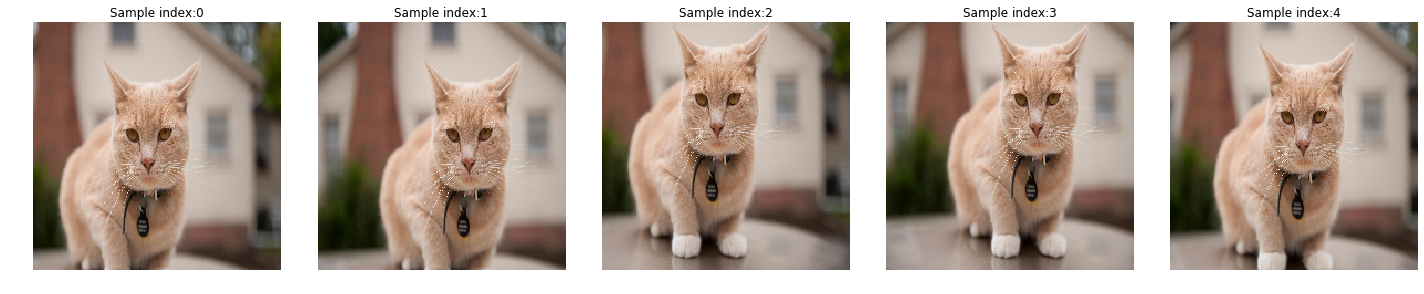

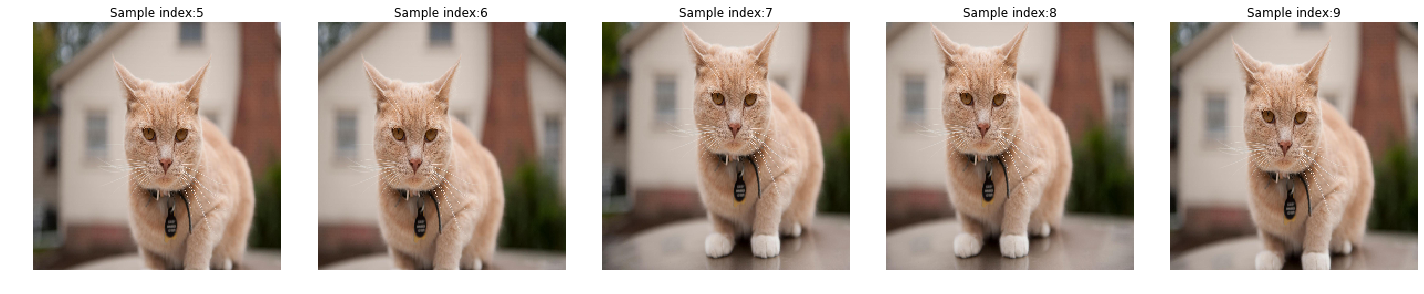

In [12]:
file_path = 'cat.jpg'
corp = Crop(file_path,size=(224,224))
fig = plt.figure(figsize=(20,30))

for i in range(5):
    image = corp()[i]
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title('Sample index:{}'.format(i))
    ax.axis('off') # trun of axis
    plt.imshow(image)
plt.show()

fig = plt.figure(figsize=(20,30))
for i in range(5,10):
    image = corp()[i]
    ax = plt.subplot(1,5,i-4)
    plt.tight_layout()
    ax.set_title('Sample index:{}'.format(i))
    ax.axis('off') # trun of axis
    plt.imshow(image)
plt.show()